# 文章の相関の可視化（共起ネットワーク）
・文章を単語へ分かち書き（分解）<br>
・単語の接続<br>
・共起ネットワークの作成<br>

NetworkX
https://networkx.org/documentation/stable/index.html

In [1]:
import MeCab#分かち書き用ライブラリ

分かち書きの基礎

In [2]:
mecab = MeCab.Tagger()
node = mecab.parseToNode("メロスは激怒した。")
while node:
    w = node.surface
    w_type = node.feature.split(',')[0]
    print(w, w_type)
    node = node.next

 BOS/EOS
メロス 名詞
は 助詞
激怒 名詞
し 動詞
た 助動詞
。 補助記号
 BOS/EOS


#### 走れメロスの最初の文の共起ネットワーク（文単位で解析）

走れメロスの最初の文だけ書かれたファイルの読み込み

In [3]:
with open("hashire_merosu_first.txt", mode="r") as f:
    text_all = f.read() 

不必要な部分（ヘッダや説明）を削除

In [4]:
import re

text = re.split(r'\-{5,}', text_all)[2]
text = re.split(r'底本：', text)[0]
text = re.sub(r'《.+?》', '', text)
text = re.sub(r'［＃.+?］', '', text)
text = re.sub(r'\n', '', text)
text = re.sub(r'「', '', text)
text = re.sub(r'」', '', text)
text = re.sub(r'\u3000', '', text)
text = text.strip()
text = text.split("。")
#text = text.split("\n")
text

['メロスは激怒した', '必ず、かの邪智暴虐の王を除かなければならぬと決意した', 'メロスには政治がわからぬ', 'メロスは、村の牧人である', '']

名詞だけ抜き出す

In [5]:
mecab = MeCab.Tagger()
for line in text:
    node = mecab.parseToNode(line)
    while node:
        w = node.surface
        w_type = node.feature.split(',')[0]
        if w_type in ["名詞"]:
            print(w, w_type)
        node = node.next

メロス 名詞
激怒 名詞
邪智 名詞
暴虐 名詞
王 名詞
決意 名詞
メロス 名詞
政治 名詞
メロス 名詞
村 名詞
牧人 名詞


文章内の単語のつながりを解析

In [6]:
mecab = MeCab.Tagger()
list_2 = []
for line in text:
    node = mecab.parseToNode(line)
    list_1 = []
    while node:
        w = node.surface
        w_type = node.feature.split(',')[0]
        if w_type in ["名詞"]:
            list_1.append(w)
        node = node.next
    if list_1:
        list_2.append(list_1)
print(sorted(list_2)) 

[['メロス', '政治'], ['メロス', '村', '牧人'], ['メロス', '激怒'], ['邪智', '暴虐', '王', '決意']]


In [7]:
from collections import defaultdict, Counter, OrderedDict
from copy import copy, deepcopy
from itertools import combinations, dropwhile

単語のペアを作成

In [8]:
pair_all = []
for list_1 in list_2:
    pair_1 = list(combinations(set(list_1), 2))
    for i,pair in enumerate(pair_1):
        pair_1[i] = tuple(sorted(pair))
    pair_all += pair_1
pair_count = Counter(pair_all)
min_cnt=0
for key, count in dropwhile(lambda key_count: key_count[1] >= min_cnt, pair_count.most_common()):
    del pair_count[key]
print(pair_count)

Counter({('メロス', '激怒'): 1, ('王', '邪智'): 1, ('決意', '邪智'): 1, ('暴虐', '邪智'): 1, ('決意', '王'): 1, ('暴虐', '王'): 1, ('暴虐', '決意'): 1, ('メロス', '政治'): 1, ('メロス', '村'): 1, ('メロス', '牧人'): 1, ('村', '牧人'): 1})


出現頻度のカウント

In [9]:
word_count = Counter()
for list_1 in list_2:
    word_count += Counter(set(list_1))
print(word_count)

Counter({'メロス': 3, '激怒': 1, '邪智': 1, '王': 1, '決意': 1, '暴虐': 1, '政治': 1, '村': 1, '牧人': 1})


jaccard係数の計算

In [10]:
jaccard_coef = []
for pair, cnt in pair_count.items():
    jaccard_coef.append(cnt / (word_count[pair[0]] + word_count[pair[1]] - cnt))
print(jaccard_coef)

[0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 1.0]


jaccard係数がedge_th未満の単語ペアを除外

In [11]:
edge_th=0.0
jaccard_dict = OrderedDict()
for (pair, cnt), coef in zip(pair_count.items(), jaccard_coef):
    if coef >= edge_th:
        jaccard_dict[pair] = coef
        print(pair, cnt, coef, word_count[pair[0]], word_count[pair[1]], sep='\t')

('メロス', '激怒')	1	0.3333333333333333	3	1
('王', '邪智')	1	1.0	1	1
('決意', '邪智')	1	1.0	1	1
('暴虐', '邪智')	1	1.0	1	1
('決意', '王')	1	1.0	1	1
('暴虐', '王')	1	1.0	1	1
('暴虐', '決意')	1	1.0	1	1
('メロス', '政治')	1	0.3333333333333333	3	1
('メロス', '村')	1	0.3333333333333333	3	1
('メロス', '牧人')	1	0.3333333333333333	3	1
('村', '牧人')	1	1.0	1	1


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'MS Gothic'
import japanize_matplotlib

import networkx as nx

C:\Users\makino\anaconda3\envs\SimBook\lib\site-packages\japanize_matplotlib\japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


グラフで表示

Number of nodes = 9
Number of edges = 11


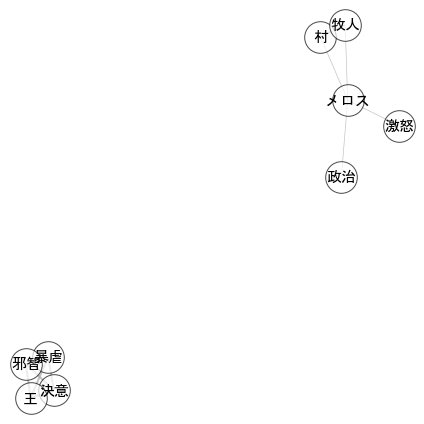

In [13]:
G = nx.Graph()
nodes = sorted(set([j for pair in jaccard_dict.keys() for j in pair]))
G.add_nodes_from(nodes)
print('Number of nodes =', G.number_of_nodes())

#  線（edge）の追加
for pair, coef in jaccard_dict.items():
    G.add_edge(pair[0], pair[1], weight=coef)

print('Number of edges =', G.number_of_edges())

plt.figure(figsize=(6, 6))

# nodeの配置方法の指定
seed = 0
np.random.seed(seed)
pos = nx.spring_layout(G, k=0.3, seed=seed)
pr = nx.pagerank(G)
nx.draw_networkx_nodes(
    G,
    pos,
    node_color='w',#list(pr.values()),
    edgecolors='k', 
#    cmap=plt.cm.rainbow,
    alpha=0.7,
    node_size=1000)#[10000*v for v in pr.values()])

# 日本語ラベルの設定
nx.draw_networkx_labels(G, pos, font_size=15, font_family='MS Gothic', font_weight='bold')

# エッジの太さをJaccard係数により変える
edge_width = [d['weight'] * 2 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color='darkgrey', width=edge_width)
plt.axis('off')
plt.tight_layout()
plt.savefig("mrs_first1.png")
plt.savefig("mrs_first1.svg")
plt.show()

#### 走れメロスの最初の文の共起ネットワーク（段落単位で解析）
ここまでのスクリプトは句点（。）で区切って解析の塊を作っていたが，以下では段落で区切って解析の塊を作る。<br>
以下のスクリプトは段落で繰りるように修正している。

In [14]:
text = re.split(r'\-{5,}', text_all)[2]
text = re.split(r'底本：', text)[0]
text = re.sub(r'《.+?》', '', text)
text = re.sub(r'［＃.+?］', '', text)
#text = re.sub(r'\n', '', text)
text = re.sub(r'「', '', text)
text = re.sub(r'」', '', text)
text = re.sub(r'\u3000', '', text)
text = text.strip()
#text = text.split("。")
text = text.split("\n")
text

['メロスは激怒した。必ず、かの邪智暴虐の王を除かなければならぬと決意した。メロスには政治がわからぬ。メロスは、村の牧人である。']

名詞だけ抜き出す

In [15]:
mecab = MeCab.Tagger()
list_2 = []
for line in text:
    node = mecab.parseToNode(line)
    list_1 = []
    while node:
        w = node.surface
        w_type = node.feature.split(',')[0]
        if w_type in ["名詞"]:
            list_1.append(w)
        node = node.next
    if list_1:
        list_2.append(list_1)
print(sorted(list_2)) 

[['メロス', '激怒', '邪智', '暴虐', '王', '決意', 'メロス', '政治', 'メロス', '村', '牧人']]


単語のペアを作成，出現頻度のカウント，jaccard係数の計算，jaccard係数がedge_th未満の単語ペアを除外

In [16]:
#単語のペアを作成
pair_all = []
for list_1 in list_2:
    pair_1 = list(combinations(set(list_1), 2))
    for i,pair in enumerate(pair_1):
        pair_1[i] = tuple(sorted(pair))
    pair_all += pair_1
pair_count = Counter(pair_all)
min_cnt=0
for key, count in dropwhile(lambda key_count: key_count[1] >= min_cnt, pair_count.most_common()):
    del pair_count[key]
print(pair_count)
#出現頻度のカウント
word_count = Counter()
for list_1 in list_2:
    word_count += Counter(set(list_1))
print(word_count)
#jaccard係数の計算
jaccard_coef = []
for pair, cnt in pair_count.items():
    jaccard_coef.append(cnt / (word_count[pair[0]] + word_count[pair[1]] - cnt))
print(jaccard_coef)
# jaccard係数がedge_th未満の単語ペアを除外
edge_th=0.0
jaccard_dict = OrderedDict()
for (pair, cnt), coef in zip(pair_count.items(), jaccard_coef):
    if coef >= edge_th:
        jaccard_dict[pair] = coef
        print(pair, cnt, coef, word_count[pair[0]], word_count[pair[1]], sep='\t')

Counter({('暴虐', '王'): 1, ('メロス', '王'): 1, ('村', '王'): 1, ('牧人', '王'): 1, ('王', '邪智'): 1, ('政治', '王'): 1, ('激怒', '王'): 1, ('決意', '王'): 1, ('メロス', '暴虐'): 1, ('暴虐', '村'): 1, ('暴虐', '牧人'): 1, ('暴虐', '邪智'): 1, ('政治', '暴虐'): 1, ('暴虐', '激怒'): 1, ('暴虐', '決意'): 1, ('メロス', '村'): 1, ('メロス', '牧人'): 1, ('メロス', '邪智'): 1, ('メロス', '政治'): 1, ('メロス', '激怒'): 1, ('メロス', '決意'): 1, ('村', '牧人'): 1, ('村', '邪智'): 1, ('政治', '村'): 1, ('村', '激怒'): 1, ('村', '決意'): 1, ('牧人', '邪智'): 1, ('政治', '牧人'): 1, ('激怒', '牧人'): 1, ('決意', '牧人'): 1, ('政治', '邪智'): 1, ('激怒', '邪智'): 1, ('決意', '邪智'): 1, ('政治', '激怒'): 1, ('政治', '決意'): 1, ('決意', '激怒'): 1})
Counter({'王': 1, '暴虐': 1, 'メロス': 1, '村': 1, '牧人': 1, '邪智': 1, '政治': 1, '激怒': 1, '決意': 1})
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
('暴虐', '王')	1	1.0	1	1
('メロス', '王')	1	1.0	1	1
('村', '王')	1	1.0	1	1
('牧人', '王')	1	1.0	1	1
('王', '邪智')	1	1.0	1	1
('政治'

Number of nodes = 9
Number of edges = 36


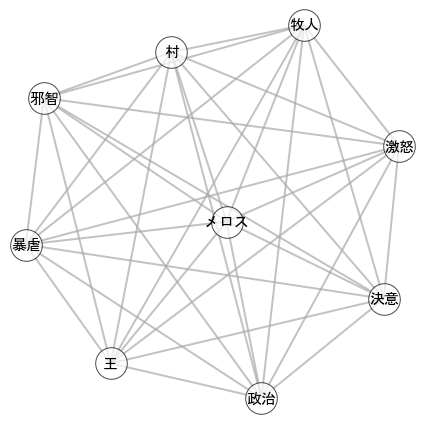

In [17]:
G = nx.Graph()
nodes = sorted(set([j for pair in jaccard_dict.keys() for j in pair]))
G.add_nodes_from(nodes)
print('Number of nodes =', G.number_of_nodes())

#  線（edge）の追加
for pair, coef in jaccard_dict.items():
    G.add_edge(pair[0], pair[1], weight=coef)

print('Number of edges =', G.number_of_edges())

plt.figure(figsize=(6, 6))

# nodeの配置方法の指定
seed = 0
np.random.seed(seed)
pos = nx.spring_layout(G, k=0.3, seed=seed)
pr = nx.pagerank(G)
nx.draw_networkx_nodes(
    G,
    pos,
    node_color='w',#list(pr.values()),
    edgecolors='k', 
#    cmap=plt.cm.rainbow,
    alpha=0.7,
    node_size=1000)#[10000*v for v in pr.values()])

# 日本語ラベルの設定
nx.draw_networkx_labels(G, pos, font_size=15, font_family='MS Gothic', font_weight='bold')

# エッジ太さをJaccard係数により変える
edge_width = [d['weight'] * 2 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color='darkgrey', width=edge_width)
plt.axis('off')
plt.tight_layout()
plt.savefig("mrs_first2.png")
plt.savefig("mrs_first2.svg")
plt.show()


#### 走れメロスの最初の文の共起ネットワーク（文全体を解析）

【手順１（１）】走れメロスの全文を読み込む

In [18]:
with open("hashire_merosu.txt", mode="r") as f:
    text_all = f.read() 

【手順１（１）】段落に分ける

In [19]:
text = re.split(r'\-{5,}', text_all)[2]
text = re.split(r'底本：', text)[0]
text = re.sub(r'《.+?》', '', text)
text = re.sub(r'［＃.+?］', '', text)
#text = re.sub(r'\n', '', text)
text = re.sub(r'「', '', text)
text = re.sub(r'」', '', text)
text = re.sub(r'\u3000', '', text)
text = text.strip()
#text = text.split("。")
text = text.split("\n")
text

['メロスは激怒した。必ず、かの邪智暴虐の王を除かなければならぬと決意した。メロスには政治がわからぬ。メロスは、村の牧人である。笛を吹き、羊と遊んで暮して来た。けれども邪悪に対しては、人一倍に敏感であった。きょう未明メロスは村を出発し、野を越え山越え、十里はなれた此のシラクスの市にやって来た。メロスには父も、母も無い。女房も無い。十六の、内気な妹と二人暮しだ。この妹は、村の或る律気な一牧人を、近々、花婿として迎える事になっていた。結婚式も間近かなのである。メロスは、それゆえ、花嫁の衣裳やら祝宴の御馳走やらを買いに、はるばる市にやって来たのだ。先ず、その品々を買い集め、それから都の大路をぶらぶら歩いた。メロスには竹馬の友があった。セリヌンティウスである。今は此のシラクスの市で、石工をしている。その友を、これから訪ねてみるつもりなのだ。久しく逢わなかったのだから、訪ねて行くのが楽しみである。歩いているうちにメロスは、まちの様子を怪しく思った。ひっそりしている。もう既に日も落ちて、まちの暗いのは当りまえだが、けれども、なんだか、夜のせいばかりでは無く、市全体が、やけに寂しい。のんきなメロスも、だんだん不安になって来た。路で逢った若い衆をつかまえて、何かあったのか、二年まえに此の市に来たときは、夜でも皆が歌をうたって、まちは賑やかであった筈だが、と質問した。若い衆は、首を振って答えなかった。しばらく歩いて老爺に逢い、こんどはもっと、語勢を強くして質問した。老爺は答えなかった。メロスは両手で老爺のからだをゆすぶって質問を重ねた。老爺は、あたりをはばかる低声で、わずか答えた。',
 '王様は、人を殺します。',
 'なぜ殺すのだ。',
 '悪心を抱いている、というのですが、誰もそんな、悪心を持っては居りませぬ。',
 'たくさんの人を殺したのか。',
 'はい、はじめは王様の妹婿さまを。それから、御自身のお世嗣を。それから、妹さまを。それから、妹さまの御子さまを。それから、皇后さまを。それから、賢臣のアレキス様を。',
 'おどろいた。国王は乱心か。',
 'いいえ、乱心ではございませぬ。人を、信ずる事が出来ぬ、というのです。このごろは、臣下の心をも、お疑いになり、少しく派手な暮しをしている者には、人質ひとりずつ差し出すことを命じて居ります。御命令を拒めば十字架にかけられて、殺

【手順１（３）】抽出する単語（登場人物）のリストを読み込む
この単語だけを対象とする。

In [20]:
with open("hashire_merosu_name.txt", mode="r") as f:
    selectwords = f.read() 
selectwords = selectwords.split("\n")
selectwords

['メロス',
 '王',
 '父',
 '母',
 '女房',
 '妹',
 '花嫁',
 'セリヌンティウス',
 '友',
 '老爺',
 '妹婿',
 '皇后',
 '賢臣',
 'アレキス',
 '国王',
 '臣下',
 '男',
 'ディオニス',
 '私',
 '村人',
 '兄',
 'ゼウス',
 '娘',
 '']

【手順１（４）】単語リストの作成

In [21]:
mecab = MeCab.Tagger()
list_2 = []
for line in text:
    #line = text[0]
    list_1 = []
    node = mecab.parseToNode(line)
    while node:
        w = node.surface
        w_type = node.feature.split(',')[0]
        
        replace_words = {
            '私': 'メロス', 
            '友': 'セリヌンティウス', 
            '国王':'ディオニス',
            '王':'ディオニス', 
            '妹':'花嫁',
        }

        for key, value in replace_words.items():
            w = w.replace(key, value)
            
        if(w_type in ["代名詞", "名詞"]) & (w in selectwords):
#        if(w_type in ["名詞"]):
            list_1.append(w)
        node = node.next
    if list_1:
        list_2.append(list_1)
#    print(list_1)
#print(sorted(list_2))

【手順２】その単語リストのすべての組み合わせのリストを作成

In [22]:
pair_all = []
for list_1 in list_2:
    pair_1 = list(combinations(set(list_1), 2))
#    print(pair_1)
    for i,pair in enumerate(pair_1):
        pair_1[i] = tuple(sorted(pair))
    pair_all += pair_1
print(pair_all)

[('メロス', '花嫁'), ('父', '花嫁'), ('女房', '花嫁'), ('母', '花嫁'), ('老爺', '花嫁'), ('セリヌンティウス', '花嫁'), ('ディオニス', '花嫁'), ('メロス', '父'), ('メロス', '女房'), ('メロス', '母'), ('メロス', '老爺'), ('セリヌンティウス', 'メロス'), ('ディオニス', 'メロス'), ('女房', '父'), ('母', '父'), ('父', '老爺'), ('セリヌンティウス', '父'), ('ディオニス', '父'), ('女房', '母'), ('女房', '老爺'), ('セリヌンティウス', '女房'), ('ディオニス', '女房'), ('母', '老爺'), ('セリヌンティウス', '母'), ('ディオニス', '母'), ('セリヌンティウス', '老爺'), ('ディオニス', '老爺'), ('セリヌンティウス', 'ディオニス'), ('皇后', '花嫁'), ('アレキス', '皇后'), ('ディオニス', '皇后'), ('皇后', '賢臣'), ('アレキス', '花嫁'), ('ディオニス', '花嫁'), ('花嫁', '賢臣'), ('アレキス', 'ディオニス'), ('アレキス', '賢臣'), ('ディオニス', '賢臣'), ('ディオニス', 'メロス'), ('メロス', '男'), ('ディオニス', 'メロス'), ('ディオニス', '男'), ('ディオニス', 'メロス'), ('ディオニス', 'メロス'), ('メロス', '花嫁'), ('ディオニス', '花嫁'), ('メロス', '花嫁'), ('セリヌンティウス', 'メロス'), ('セリヌンティウス', '花嫁'), ('ディオニス', '男'), ('ディオニス', 'メロス'), ('セリヌンティウス', 'メロス'), ('セリヌンティウス', 'ディオニス'), ('メロス', '花嫁'), ('メロス', '村人'), ('メロス', '兄'), ('村人', '花嫁'), ('兄', '花嫁'), ('兄', '村人'), ('メロス', '花嫁'), ('男', '花嫁'), ('ディオニス', '

【手順３】単語の【登場回数が設定した値】より小さい場合，その単語を含む組み合わせを削除min_cnt=2を変更する。

In [23]:
pair_count = Counter(pair_all)
min_cnt=2
for key, count in dropwhile(lambda key_count: key_count[1] >= min_cnt, pair_count.most_common()):
    del pair_count[key]
#print(pair_count)

【手順４】Jaccard係数を計算し，【Jaccard係数が設定した値】より小さい組み合わせを削除edge_th=0.1の値を変更する。

In [24]:
word_count = Counter()
for list_1 in list_2:
    word_count += Counter(set(list_1))
#print(word_count)
jaccard_coef = []
for pair, cnt in pair_count.items():
    jaccard_coef.append(cnt / (word_count[pair[0]] + word_count[pair[1]] - cnt))
print(jaccard_coef)
# jaccard係数がedge_th未満の単語ペアを除外
edge_th=0.1
jaccard_dict = OrderedDict()
for (pair, cnt), coef in zip(pair_count.items(), jaccard_coef):
    if coef >= edge_th:
        jaccard_dict[pair] = coef
        print(pair, cnt, coef, word_count[pair[0]], word_count[pair[1]], sep='\t')

[0.1956521739130435, 0.2, 0.2222222222222222, 0.26666666666666666, 0.24528301886792453, 0.12903225806451613, 0.13333333333333333, 0.16, 0.06818181818181818, 0.045454545454545456, 0.16666666666666666, 0.125, 0.045454545454545456]
('メロス', '花嫁')	9	0.1956521739130435	44	11
('セリヌンティウス', '花嫁')	4	0.2	13	11
('ディオニス', '花嫁')	6	0.2222222222222222	22	11
('セリヌンティウス', 'メロス')	12	0.26666666666666666	13	44
('ディオニス', 'メロス')	13	0.24528301886792453	22	44
('セリヌンティウス', 'ディオニス')	4	0.12903225806451613	13	22
('メロス', '男')	6	0.13333333333333333	44	7
('ディオニス', '男')	4	0.16	22	7
('村人', '花嫁')	2	0.16666666666666666	3	11
('男', '花嫁')	2	0.125	7	11


In [25]:
word_count = Counter()
for list_1 in list_2:
    word_count += Counter(set(list_1))
    print(Counter(set(list_1)))
print(word_count)
list_2

Counter({'花嫁': 1, 'メロス': 1, '父': 1, '女房': 1, '母': 1, '老爺': 1, 'セリヌンティウス': 1, 'ディオニス': 1})
Counter({'ディオニス': 1})
Counter({'皇后': 1, '花嫁': 1, 'アレキス': 1, 'ディオニス': 1, '賢臣': 1})
Counter({'ディオニス': 1})
Counter({'臣下': 1})
Counter({'メロス': 1, 'ディオニス': 1})
Counter({'メロス': 1, '男': 1, 'ディオニス': 1})
Counter({'ディオニス': 1})
Counter({'メロス': 1})
Counter({'ディオニス': 1})
Counter({'メロス': 1, 'ディオニス': 1})
Counter({'メロス': 1})
Counter({'ディオニス': 1})
Counter({'メロス': 1, 'ディオニス': 1, '花嫁': 1})
Counter({'メロス': 1, '花嫁': 1, 'セリヌンティウス': 1})
Counter({'男': 1, 'ディオニス': 1})
Counter({'メロス': 1})
Counter({'メロス': 1, 'ディオニス': 1, 'セリヌンティウス': 1})
Counter({'メロス': 1, '花嫁': 1, '村人': 1, '兄': 1})
Counter({'メロス': 1})
Counter({'花嫁': 1})
Counter({'メロス': 1})
Counter({'花嫁': 1, 'メロス': 1, '男': 1, 'ディオニス': 1, '村人': 1})
Counter({'メロス': 1, '男': 1, '兄': 1})
Counter({'メロス': 1, '花嫁': 1})
Counter({'メロス': 1, '花嫁': 1})
Counter({'メロス': 1, '村人': 1})
Counter({'メロス': 1, 'ディオニス': 1})
Counter({'花嫁': 1, 'メロス': 1, 'セリヌンティウス': 1, 'ゼウス': 1, 'ディオニス': 1})
Counter({'メ

[['メロス',
  'ディオニス',
  'メロス',
  'メロス',
  'メロス',
  'メロス',
  '父',
  '母',
  '女房',
  '花嫁',
  '花嫁',
  'メロス',
  '花嫁',
  'メロス',
  'セリヌンティウス',
  'セリヌンティウス',
  'セリヌンティウス',
  'メロス',
  'メロス',
  '老爺',
  '老爺',
  'メロス',
  '老爺',
  '老爺'],
 ['ディオニス'],
 ['ディオニス', '花嫁', '花嫁', '皇后', '賢臣', 'アレキス'],
 ['ディオニス'],
 ['臣下'],
 ['メロス', 'ディオニス'],
 ['メロス', '男', 'メロス', 'メロス', 'ディオニス'],
 ['ディオニス', 'ディオニス'],
 ['メロス'],
 ['ディオニス'],
 ['メロス', 'ディオニス'],
 ['メロス'],
 ['ディオニス'],
 ['ディオニス', 'メロス', 'メロス', 'メロス', '花嫁', 'メロス'],
 ['メロス', 'メロス', 'メロス', '花嫁', 'メロス', 'メロス', 'セリヌンティウス', 'メロス', 'メロス'],
 ['ディオニス', '男', '男'],
 ['メロス'],
 ['セリヌンティウス',
  'セリヌンティウス',
  'ディオニス',
  'セリヌンティウス',
  'セリヌンティウス',
  'メロス',
  'セリヌンティウス',
  'セリヌンティウス',
  'メロス',
  'セリヌンティウス',
  'セリヌンティウス',
  'セリヌンティウス',
  'メロス'],
 ['メロス', '村人', 'メロス', '花嫁', '兄', '兄', '兄'],
 ['メロス'],
 ['花嫁'],
 ['メロス'],
 ['メロス', 'メロス', '村人', 'メロス', 'ディオニス', 'メロス', 'メロス', 'メロス', '男', '花嫁'],
 ['メロス', 'メロス', '兄', '兄', '男'],
 ['花嫁', 'メロス'],
 ['メロス', '花嫁', 'メロス'],
 ['メロス', '村人'],
 ['メロス', 'ディオニス'

【手順５】ネットワークの作成

Number of nodes = 6
Number of edges = 10


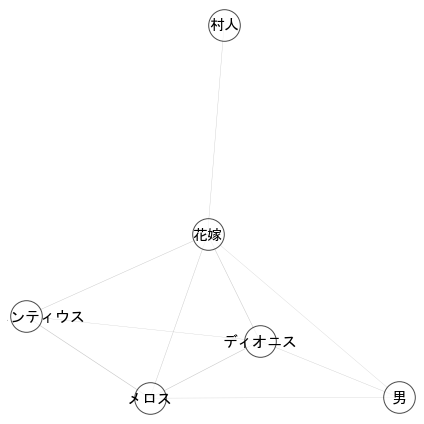

In [26]:
G = nx.Graph()
nodes = sorted(set([j for pair in jaccard_dict.keys() for j in pair]))
G.add_nodes_from(nodes)
print('Number of nodes =', G.number_of_nodes())

#  線（edge）の追加
for pair, coef in jaccard_dict.items():
    G.add_edge(pair[0], pair[1], weight=coef)

print('Number of edges =', G.number_of_edges())

plt.figure(figsize=(6, 6))

# nodeの配置方法の指定
seed = 0
np.random.seed(seed)
pos = nx.spring_layout(G, k=0.3, seed=seed)
pr = nx.pagerank(G)
nx.draw_networkx_nodes(
    G,
    pos,
    node_color='w',#list(pr.values()),
    edgecolors='k', 
#    cmap=plt.cm.rainbow,
    alpha=0.7,
    node_size=1000)#[10000*v for v in pr.values()])

# 日本語ラベルの設定
nx.draw_networkx_labels(G, pos, font_size=15, font_family='MS Gothic', font_weight='bold')

# エッジ太さをJaccard係数により変える
edge_width = [d['weight'] * 2 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color='darkgrey', width=edge_width)
plt.axis('off')
plt.tight_layout()
plt.savefig("mrs_all.png")
plt.savefig("mrs_all.svg")
plt.show()

#### レビューの共起ネットワーク

In [27]:
with open("camera_review.txt", mode="r") as f:
    text_all = f.read() 

In [28]:
text = text_all
#text = re.split(r'\-{5,}', text)[2]
#text = re.split(r'底本：', text)[0]
text = re.sub(r'【.+?】', '', text)
#text = re.sub(r'［＃.+?］', '', text)
text = re.sub(r'\n', '', text)
text = re.sub(r'「', '', text)
text = re.sub(r'」', '', text)
text = re.sub(r'★', '', text)
#text = re.sub(r'\u3000', '', text)
#text = text.strip()
#text = text.split("。")
text = text.split("@@@@@")

In [29]:
mecab = MeCab.Tagger()
list_2 = []
for line in text:
    #line = text[0]
    list_1 = []
    node = mecab.parseToNode(line)
    while node:
        w = node.surface
        w_type = node.feature.split(',')[0]
        for key, value in replace_words.items():
            w = w.replace(key, value)
            
        if(w_type in ["名詞"]):
            list_1.append(w)
        node = node.next
    if list_1:
        list_2.append(list_1)
#    print(list_1)
#print(sorted(list_2))

pair_all = []
for list_1 in list_2:
    pair_1 = list(combinations(set(list_1), 2))
#    print(pair_1)
    for i,pair in enumerate(pair_1):
        pair_1[i] = tuple(sorted(pair))
    pair_all += pair_1
#print(pair_all)
pair_count = Counter(pair_all)
min_cnt=8
for key, count in dropwhile(lambda key_count: key_count[1] >= min_cnt, pair_count.most_common()):
    del pair_count[key]
#print(pair_count)

word_count = Counter()
for list_1 in list_2:
    word_count += Counter(set(list_1))
#print(word_count)
jaccard_coef = []
for pair, cnt in pair_count.items():
    jaccard_coef.append(cnt / (word_count[pair[0]] + word_count[pair[1]] - cnt))
#print(jaccard_coef)
# jaccard係数がedge_th未満の単語ペアを除外
edge_th=0.6#0.6
jaccard_dict = OrderedDict()
for (pair, cnt), coef in zip(pair_count.items(), jaccard_coef):
    if coef >= edge_th:
        jaccard_dict[pair] = coef
#        print(pair, cnt, coef, word_count[pair[0]], word_count[pair[1]], sep='\t')


Number of nodes = 12
Number of edges = 11


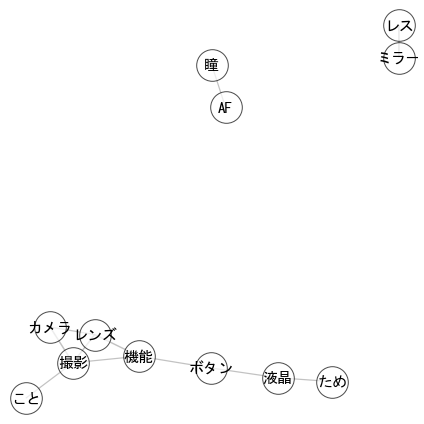

In [30]:
G = nx.Graph()
nodes = sorted(set([j for pair in jaccard_dict.keys() for j in pair]))
G.add_nodes_from(nodes)
print('Number of nodes =', G.number_of_nodes())

#  線（edge）の追加
for pair, coef in jaccard_dict.items():
    G.add_edge(pair[0], pair[1], weight=coef)

print('Number of edges =', G.number_of_edges())

plt.figure(figsize=(6, 6))

# nodeの配置方法の指定
seed = 0
np.random.seed(seed)
pos = nx.spring_layout(G, k=0.3, seed=seed)
pr = nx.pagerank(G)
nx.draw_networkx_nodes(
    G,
    pos,
    node_color='w',#list(pr.values()),
    edgecolors='k', 
#    cmap=plt.cm.rainbow,
    alpha=0.7,
    node_size=1000)#[10000*v for v in pr.values()])

# 日本語ラベルの設定
nx.draw_networkx_labels(G, pos, font_size=15, font_family='MS Gothic', font_weight='bold')

# エッジ太さをJaccard係数により変える
edge_width = [d['weight'] * 2 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color='darkgrey', width=edge_width)
plt.axis('off')
plt.tight_layout()
plt.savefig("review.png")
plt.savefig("review.svg")
plt.show()